# Regressão Logística com Regularização

## Objetivos

Com este código, você irá:
- Modificar as funções do nosso código anterior, para agora contemplar a Regularização.
- Note que testaremos nosso algoritmo regularizado num novo conjunto de dados que exigirá a adição de termos polinomiais ao modelo

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from utils import *
# from nossa_biblioteca_de_funcoes import *   # Importando as funções auxiliares que usaremos nesse código

Neste código, você implementará a Regressão Logística com Regularização para prever se os microchips de uma fábrica passam num determinado teste de garantia de qualidade (GQ). Durante tal teste de GQ, cada microchip passa por diversos testes que garantem que ele está funcionando corretamente.

### Definição do Problema

Suponha que você seja o gerente de produto de uma fábrica e você têm acesso aos resultados para dois diferentes testes realizados nos microchips
- Destes dois testes, você gostaria de determinar se os chips devem ser aprovados ou rejeitados
- Para ajudar na sua tomada de decisão, você tem um banco de dados contendo os resultados de microchips passados. Você usará esses dados para construir um modelo de Regressão Logística


## Carregando os dados:

In [2]:
file = open('dados_microchip.txt') # As duas primeiras colunas referem-se às características -> resultados obtidos pelos microchips nos teste 1 e 2
                                   # A terceira (última) coluna refere-se ao resultado do teste de GQ (1 significa chip aprovado)
dados = np.loadtxt(file, delimiter=",") 

X_train = dados[:,0:2]
y_train = dados[:,-1] # pega apenas a última coluna.

Vizualizando numericamente os dados:

In [3]:
# print X_train
print("X_train:", X_train[:5])
print("Tipo do X_train:",type(X_train))

# print y_train
print("y_train:", y_train[:5])
print("Tipo do y_train:",type(y_train))

X_train: [[ 0.051267  0.69956 ]
 [-0.092742  0.68494 ]
 [-0.21371   0.69225 ]
 [-0.375     0.50219 ]
 [-0.51325   0.46564 ]]
Tipo do X_train: <class 'numpy.ndarray'>
y_train: [1. 1. 1. 1. 1.]
Tipo do y_train: <class 'numpy.ndarray'>


#### Cheque as dimensões das suas variáveis


Uma outra forma útil para se familizarizar com os dados é visualizar suas dimensões.
Vamos dar print dos shapes de `X_train` e `y_train`para verificar quantas amostras de treinamento nós temos no nosso conjunto de dados.


In [4]:
print ('O shape de X_train é: ' + str(X_train.shape))
print ('O shape de y_train é: ' + str(y_train.shape))
print ('Nós temos %d exemplos (amostras) de treinamento' % (len(y_train)))

O shape de X_train é: (118, 2)
O shape de y_train é: (118,)
Nós temos 118 exemplos (amostras) de treinamento


Plotando os dados:

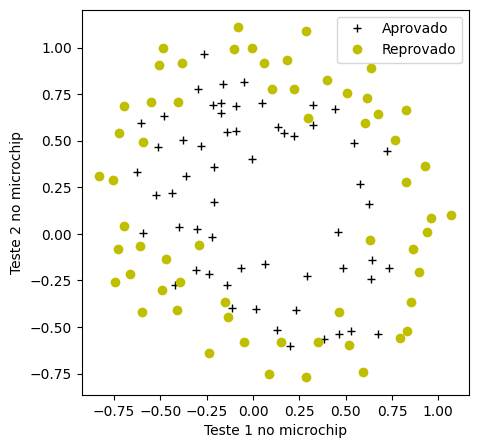

In [5]:
pos = y_train == 1 # identifica os elementos em y que são iguais a 1
neg = y_train == 0 # identifica os elementos em y que são iguais a 0

fig,ax = plt.subplots(1,1,figsize=(5,5))
ax.plot(X_train[pos,0], X_train[pos,1], 'k+', label="Aprovado")
ax.plot(X_train[neg,0], X_train[neg,1], 'yo', label="Reprovado")

#ax.axis([0, 4, 0, 3.5])
ax.set_ylabel('Teste 2 no microchip')
ax.set_xlabel('Teste 1 no microchip')
ax.legend()
plt.show()

A figura acima mostra que nosso conjunto de dados não pode ser separado em amostras positivas e negativas usando uma reta. Logo, uma aplicação direta da Regressão Logística não irá performar bem nesse conjunto de dados umas vez que a Regressão Logística não conseguirá encontrar uma Fronteira de Decisão linear adequada.

### Mapeamento de características


Uma forma de ajustar os dados melhor é criar mais características para cada amostra. Na função `mapeia_caracteristicas`, nós vamos mapear as características para todos os termos polinomiais de $x_1$ e $x_2$ até a sexta potência.

$$\mathrm{mapeia\_caracteristicas}(x) = 
\left[\begin{array}{c}
x_1\\
x_2\\
x_1^2\\
x_1 x_2\\
x_2^2\\
x_1^3\\
\vdots\\
x_1 x_2^5\\
x_2^6\end{array}\right]$$

Como um resultado desse mapeamento, nosso vetor de duas características (as pontuações nos dois testes) foi transformado em um vetor de 27 dimensões.
- Um classificador de regressão logística treinado para essa dimensão elevada terá uma fronteira de decisão complexa e será não linear ao plotarmos ela num gráfico com 2 dimensões.
- A função `mapeia_caracteristicas` está sendo fornecida (não é necessário programá-la) dentro do arquivo nossa_biblioteca_de_funcoes.py. 
- Visite o arquivo nossa_biblioteca_de_funcoes.py para ver como a função `mapeia_caracteristicas` foi escrita.

In [6]:
# def mapeia_caracteristicas(X1, X2):
#     """
#     Feature mapping function to polynomial features    
#     """
#     X1 = np.atleast_1d(X1)
#     X2 = np.atleast_1d(X2)
#     degree = 6
#     out = []
#     for i in range(1, degree+1):
#         for j in range(i + 1):
#             out.append((X1*(i-j) * (X2*j)))
#     return np.stack(out, axis=1)

In [7]:
print("Shape original dos dados:", X_train.shape)

mapped_X = mapeia_caracteristicas(X_train[:, 0], X_train[:, 1])
print("Shape após o mapeamento de características:", mapped_X.shape)

Shape original dos dados: (118, 2)
Shape após o mapeamento de características: (118, 27)


Vamos também plotar os primeiros elementos de `X_train` e `mapped_X` para vermos a transformação.

In [122]:
print("X_train[0]:", X_train[0])
print("mapped X_train[0]:", mapped_X[0])

X_train[0]: [0.051267 0.69956 ]
mapped X_train[0]: [0.         0.         0.         0.03586434 0.         0.
 0.07172869 0.07172869 0.         0.         0.10759303 0.14345737
 0.10759303 0.         0.         0.14345737 0.21518606 0.21518606
 0.14345737 0.         0.         0.17932171 0.28691474 0.32277908
 0.28691474 0.17932171 0.        ]


Uma vez que o mapeamento de características nos permite construir um classificador mais expressivo, ele também está mais suscetível ao overfitting. Para lidar com esse problema, a seguir nós implementamos o método de Regressão Logística com Regularização.

## Função Custo com Regularização

Na Regressão Logística com regularização, a função custo tem a forma 

$$ J(\mathbf{w},b) = \frac{1}{m} \sum_{i=0}^{m-1} \left[ -y^{(i)} \log\left(f_{\mathbf{w},b}\left( \mathbf{x}^{(i)} \right) \right) - \left( 1 - y^{(i)}\right) \log \left( 1 - f_{\mathbf{w},b}\left( \mathbf{x}^{(i)} \right) \right) \right] + \frac{\lambda}{2m}  \sum_{j=0}^{n-1} w_j^2 \tag{1}$$

onde    
*  m é o número de amostras de treinamento, n é o número de características e:
$$
\begin{align}
  f_{\mathbf{w},b}(\mathbf{x^{(i)}}) &= g(z^{(i)})\tag{3} \\
  z^{(i)} &= \mathbf{w} \cdot \mathbf{x}^{(i)}+ b\tag{4} \\
  g(z^{(i)}) &= \frac{1}{1+e^{-z^{(i)}}}\tag{5} 
\end{align}
$$
 

#### Descrição do Código abaixo:

A função `calcula_custo_RegLog` abaixo faz um loop passando por todas as amostras e calculando a perda para cada exemplo.
O total então é computado e depois divido por m. Por fim, o termo relativo à Regularização é adicionado

Note que as variáveis X e y não são escalares mas sim matrizes de shape ($m, n$) e ($𝑚$,) respectivamente, onde  $𝑛$ é o número de características e $𝑚$ é o número de amostras de treinamento.


In [8]:
def calcula_custo_RegLog_com_regu(X, y, w, b, lambda_ = 1):
    """
    Calcula a função custo para Regressão Logística com Regularização

    Argumentos:
      X (ndarray (m,n)): Dados, m exemplos com n características
      y (ndarray (m,)) : valores alvo
      w (ndarray (n,)) : parâmetros do modelo  
      b (escalar)      : parâmetro do modelo
      lambda_ : (escalar, float):    Controla a quantidade de regularização presente no modelo (default = 1)
      
    Retorna:
      custo (escalar): custo
    """

    m = X.shape[0]
    custo = 0.0
    for i in range(m):
        z_i = np.dot(X[i],w) + b
        f_wb_i = sigmoid(z_i)
        custo +=  -y[i]*np.log(f_wb_i) - (1-y[i])*np.log(1-f_wb_i)
         
    custo = custo / m
    
    # Abaixo calculamos o termo (custo) associado à regularização:
    custo_reg =  (lambda_/(2 * m))*sum(np.square(w))
            
    custo = custo + custo_reg
    
    return custo


Rode o código abaixo para checar a nossa implementação da função `calcula_custo_RegLog_com_regu`

In [9]:
X_mapped = mapeia_caracteristicas(X_train[:, 0], X_train[:, 1])
print(X_mapped.shape)

np.random.seed(1)
initial_w = np.random.rand(X_mapped.shape[1]) - 0.5  # O que este comando faz?
initial_b = 0.5
lambda_   = 0.5
custo     = calcula_custo_RegLog_com_regu(X_mapped, y_train, initial_w, initial_b, lambda_)

print("Custo regularizado :", custo)

(118, 27)
Custo regularizado : 0.918910032432811


**Resultado esperado**:
<table>
  <tr>
    <td> <b>Custo regularizado : <b></td>
    <td> 0.6618252552483948 </td> 
  </tr>
</table>

# Método do Gradiente com Regularização


Lembre-se que o Método do Gradiente implementa a seguinte lógica:
$$\begin{align*}
&\text{repetir até convergir:} \; \lbrace \\
&  \; \; \;w_j = w_j -  \alpha \frac{\partial J(\mathbf{w},b)}{\partial w_j} \tag{1}  \; & \text{para j := 0..n-1} \\ 
&  \; \; \;  \; \;b = b -  \alpha \frac{\partial J(\mathbf{w},b)}{\partial b} \\
&\rbrace
\end{align*}$$

Onde cada iteração performa atualização simultanea de $w_j$ para todo $j$ e para $b$, onde
$$\begin{align*}
\frac{\partial J(\mathbf{w},b)}{\partial w_j}  &= \left( \frac{1}{m}  \sum_{i=0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)}) x_j^{(i)} \right) + \frac{\lambda}{m} w_j  \tag{2} \\
\frac{\partial J(\mathbf{w},b)}{\partial b}  &= \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)}) \tag{3} 
\end{align*}$$

* $f_{\mathbf{w},b}(x^{(i)})$ é a previsão feita pelo modelo, sendo $y^{(i)}$ o alvo
* Para o modelo de Regressão Logística:
    $z = \mathbf{w} \cdot \mathbf{x} + b$  
    $f_{\mathbf{w},b}(x) = g(z)$  
    sendo $g(z)$ a função sigmoide:  
    $g(z) = \frac{1}{1+e^{-z}}$   
    

## Implementação do Método do Gradiente:

O algoritmo do Método do Gradiente possui duas componentes: 
- O loop que implementa a equação (1) acima. Essa é a função metodo_do_gradiente_RegLog_com_regu abaixo.
- O cálculo do gradiente atual, dado pelas equações (2) e (3) acima. Essa é a função calcula_gradiente_RegLog_com_regu abaixo.

#### Cálculo do gradiente: descrição do código:
Implementa as equações (2) e (3) acima para todo $w_j$ e $b$.

Há muitas formas para se implementar isso. Abaixo fazemos da seguinte maneira:
- Inicializamos as variáveis para acumular `dj_dw` e `dj_db`
- Para cada exemplo:
    - Calcula-se o erro para esse exemplo, $g(\mathbf{w} \cdot \mathbf{x}^{(i)} + b) - \mathbf{y}^{(i)}$
    - Para cada valor de entrada $x_{j}^{(i)}$ nesse exemplo,  
        - multiplica o erro pela entrada  $x_{j}^{(i)}$, e adiciona ao elemento correspondente de `dj_dw`. (Equação 2 acima)
    - adiciona o erro para `dj_db` (Equação 3 acima)

- divide-se `dj_db` e `dj_dw` pelo número total de amostras (m)
- Note que $\mathbf{x}^{(i)}$ em Numpy é `X[i,:]` ou `X[i]`  e que $x_{j}^{(i)}$ é `X[i,j]`

In [77]:
def calcula_gradiente_RegLog_com_regu(X, y, w, b, lambda_ = 1): 
    """
    Calcula Gradiente para Regressão Linear
    Argumentos:
      X (ndarray (m,n)): Dados, contendo m exemplos com n características
      y (ndarray (m,)) : valores alvo
      w (ndarray (n,)) : parâmetros w do modelo  
      b (scalar)       : parâmetro b do modelo
      lambda_ : (escalar, float):    Controla a quantidade de regularização presente no modelo (default = 1)
      
    Retorna:
      dj_dw (ndarray (n,)): O gradiente da função custo com relação aos parâmetros w. 
      dj_db (escalar):      O gradiente da função custo com relação ao parâmetro b. 
    """
    m,n = X.shape
    dj_dw = np.zeros((n,))                           #(n,)
    dj_db = 0.

    for i in range(m):
        f_wb_i = sigmoid(np.dot(X[i],w) + b)          #(n,)(n,)=scalar
        err_i  = f_wb_i  - y[i]                       #scalar
        for j in range(n):
            dj_dw[j] = dj_dw[j] + err_i * X[i,j]      #scalar
        dj_db = dj_db + err_i
    dj_dw = dj_dw/m                                   #(n,)
    dj_db = dj_db/m                                   #scalar
    
    # Com o for abaixo, adicionamos às derivadas a parte que corresponde à regularização
    for j in range(n):
        dj_dw[j] = dj_dw[j] + (lambda_/m) * w[j]
        
    return dj_db, dj_dw

Rode o código abaixo para checar a nossa implementação da função `calcula_gradiente_RegLog_com_regu`

In [78]:
X_mapped = mapeia_caracteristicas(X_train[:, 0], X_train[:, 1])
np.random.seed(1) 
initial_w  = np.random.rand(X_mapped.shape[1]) - 0.5 
initial_b = 0.5
 
lambda_ = 0.5
dj_db, dj_dw = calcula_gradiente_RegLog_com_regu(X_mapped, y_train, initial_w, initial_b, lambda_)

print(f"dj_db: {dj_db}", )
print(f"Primeiros 4 elementos dj_dw regularizado:\n {dj_dw[:4].tolist()}", )

dj_db: 0.07879080032365197
Primeiros 4 elementos dj_dw regularizado:
 [-0.0003516016749890932, 0.0009335783620430428, -0.002118159428740064, 0.058134558546671516]


**Resultados esperados**:
<table>
  <tr>
    <td> <b>dj_db:</b>0.07138288792343656</td> </tr>
  <tr>
      <td> <b> Primeiros 4 elementos dj_dw regularizado:</b> </td> </tr>
   <tr>
   <td> [[-0.010386028450548701], [0.01140985288328012], [0.0536273463274574], [0.003140278267313462]] </td> 
  </tr>
</table>

#### Método do Gradiente: descrição do código

O código que implementa a Equação (1) acima é fornecido abaixo. Tire um momento para entender o que está sendo calculado e como isso é feito.


In [79]:
def metodo_do_gradiente_RegLog_com_regu(X, y, w_in, b_in, alpha, num_iters, lambda_): 
    """
    Performa Método do Gradiente para aprender w e b. Atualiza w e b ao longo de  
    num_iters passos de iteração usando uma taxa de aprendizado alpha
    
    Argumentos:
      X (ndarray (m,n))      : Dados, contendo m exemplos com n características
      y (ndarray (m,))       : valores alvo
      w_in (ndarray (n,))    : valores iniciais dos parâmetros w do modelo  
      b_in (escalar)         : valor inicial do parâmetro b do modelo
      alpha (float)          : taxa de aprendizado
      num_iters (int)        : Número de iterações para o método do gradiente
      lambda_(scalar, float) : Constante de Regularização
      
    Retorna:
      w (ndarray (n,)) : Valores atualizados para os parâmetros w
      b (scalar)       : Valores atualizado para o parâmetro b 
      """
    
    # Valores históricos
    J_history = []
    w = w_in
    b = b_in
    
    for i in range(num_iters):
        # Calculando o gradiente
        dj_db, dj_dw = calcula_gradiente_RegLog_com_regu(X, y, w, b, lambda_)   

        # Atualizando os parâmetros com base em alpha e nos gradientes
        w = w - alpha * dj_dw               
        b = b - alpha * dj_db               
      
        # Salva J para cada iteração
        if i<100000:      # prevent resource exhaustion 
            J_history.append( calcula_custo_RegLog_com_regu(X, y, w, b, lambda_) )

        # Faz o print da função custo de tempos em tempos
        if i% math.ceil(num_iters / 10) == 0:
            print(f"Iteração {i:4d}: Custo {J_history[-1]}   ")
        
    return w, b, J_history         #retorna os valores finais w,b e J history para plotar curva de aprendizado


Vamos agora rodar a Regressão Logística para os nossos dados.
- O bloco de código abaixo demora um tempo para rodar, especialmente com uma implementação não vetorizada. Você pode reduzir o número de `iterações` para testar sua implementação mais rapidamente. Se você tiver tempo, rode por 100000 iterações para obter resultados melhores.

In [107]:
# Inicializando os parâmetros do modelo
np.random.seed(1)
initial_w = np.random.rand(X_mapped.shape[1])-0.5  # atribui um valor inicial aleatório para os parâmetros w_j
initial_b = 1.

# Definindo o parâmetro de regularização (fique a vontade para variá-lo)
lambda_ = 0.001;                                          
# Outras definições para o método do gradiente:
iterations = 10000
alpha = 0.01

w_out, b_out, _ = metodo_do_gradiente_RegLog_com_regu(X_mapped, y_train, initial_w, initial_b, alpha, iterations, lambda_) 
print(f"\nparâmetros finais: w:{w_out}, b:{b_out}")


Iteração    0: Custo 0.9658586048519252   
Iteração 1000: Custo 0.688577267547507   
Iteração 2000: Custo 0.6874737587915811   
Iteração 3000: Custo 0.6874653710743337   
Iteração 4000: Custo 0.6874653053780954   
Iteração 5000: Custo 0.6874653032310031   
Iteração 6000: Custo 0.6874653015697195   
Iteração 7000: Custo 0.6874652999124261   
Iteração 8000: Custo 0.6874652982554424   
Iteração 9000: Custo 0.6874652965987396   

parâmetros finais: w:[-0.0829077   0.22013786 -0.49946217 -0.21249698 -0.35294488 -0.40731608
 -0.34346801 -0.18430243 -0.10314508  0.03878385 -0.12572802  0.12507463
 -0.34028837  0.37779713 -0.47221206  0.11033513 -0.17260711 -0.03134185
 -0.41929641 -0.30164277  0.30048981  0.39287994 -0.30639372  0.05718676
  0.25609436  0.31928742 -0.41460428], b:-0.05868211756337016


**Resultado Esperado: Custo $<$ 0.5**

## Plotando a Fronteira de Decisão

Para lhe auxiliar na visualização do modelo treinado pelo classificador, nós usaremos a nossa função `plota_fronteira_decisao` que plota a fronteira de decisão não linear que separa os exemplos positivos dos negativos.

- Na função, nós plotamos a fronteira de decisão não linear computando as previsões do classificador numa grid igualmente espaçada e então desenhamos o gráfico de contorno onde as previsões mudam de y = 0 para y = 1.

In [108]:
def plot_data(X, y, pos_label="y=1", neg_label="y=0"):
	# Esta função é chamada pela função plota_fronteira_decisao
    positive = y == 1
    negative = y == 0
    
    # Plot examples
    plt.plot(X[positive, 0], X[positive, 1], 'k+', label=pos_label)
    plt.plot(X[negative, 0], X[negative, 1], 'yo', label=neg_label)
    
def plota_fronteira_decisao(w, b, X, y):
    # Credit to dibgerge on Github for this plotting code
     
    plot_data(X[:, 0:2], y)
    
    if X.shape[1] <= 2:
        plot_x = np.array([min(X[:, 0]), max(X[:, 0])])
        plot_y = (-1. / w[1]) * (w[0] * plot_x + b)
        
        plt.plot(plot_x, plot_y, c="b")
        
    else:
        u = np.linspace(-1, 1.5, 50)
        v = np.linspace(-1, 1.5, 50)
        
        z = np.zeros((len(u), len(v)))

        # Evaluate z = theta*x over the grid
        for i in range(len(u)):
            for j in range(len(v)):
                z[i,j] = sigmoid(np.dot(mapeia_caracteristicas(u[i], v[j]), w) + b)
        
        # important to transpose z before calling contour       
        z = z.T
        
        # Plot z = 0
        plt.contour(u,v,z, levels = [0.5], colors="g")

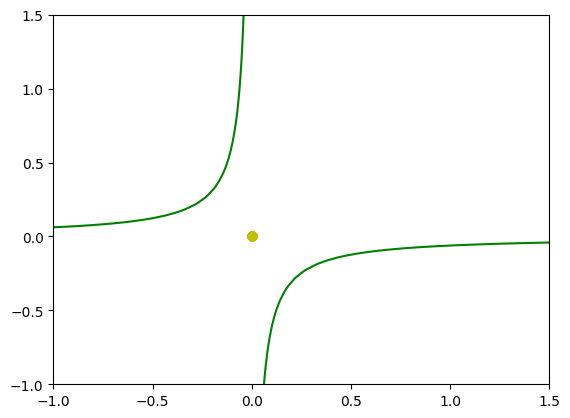

In [109]:
plota_fronteira_decisao(w_out, b_out, X_mapped, y_train)

## Fazendo previsões:

Agora você pode ver as previsões feitas por este modelo chamando a nossa função `probab_e_previsao`. Ela irá fornecer as probabilidades calculadas pelo modelo para cada amostra e então produz as previsões 1 ou 0 com base nessas probabilidades.

- Primeiro, é necessário calcular a probabilidade de $y$ ser 1 a partir do modelo $f(x^{(i)}) = g(w \cdot x^{(i)}+b)$ para cada amostra. Isso considerando parâmetros $w$ e $b$ para o modelo.
- Então, para obter uma previsão final ($y^{(i)}=0$ ou $y^{(i)}=1$) do modelo de regressão logística, nós usamos a seguinte heurística:

  se $f(x^{(i)}) >= 0.5$, prever $y^{(i)}=1$
  
  se $f(x^{(i)}) < 0.5$, prever $y^{(i)}=0$
    

In [101]:
def probab_e_previsao(X, w, b): 
    """
    Prevê se o rótulo é 0 ou 1 usando modelo de regressão logística com parâmetros w e b
    
    Argumentos:
    X : (ndarray Shape (m, n))       Dados
    w : (array_like Shape (n,))      Parâmetros do modelo
    b : (scalar, float)              Parâmetro do modelo

    Retorna:
    probab:   (ndarray (m,1))        Probabilidade de y ser 1 para cada amostra
    previsao: (ndarray (m,1))        Previsão final para cada amostra usando limiar de 0.5
    """
    # número de amostras de treinamento
    m, n     = X.shape   
    probab   = np.zeros(m)
    previsao = np.zeros(m)
   
    # passando por cada amostra
    for i in range(m):   
        z_wb = np.dot(X[i],w) 
        
        # adiciona termo de bias
        z_wb += b
        
        # calcula a probabilidade para esse exemplo
        f_wb      = sigmoid(z_wb)
        probab[i] = f_wb

        # Aplica o valor limiar para geral a previsão final
        previsao[i] = 1 if f_wb>0.5 else 0

    return probab, previsao

In [102]:
# Calculando probalidade e previsão correspondente para cada amostra do conjunto de dados de treinamento
probab, previsao = probab_e_previsao(X_mapped, w_out, b_out)

print(np.c_[probab, previsao])

print('Taxa de acerto para dados de treinamento: %f'%(np.mean(previsao == y_train) * 100))

[[0.47681024 0.        ]
 [0.50045234 1.        ]
 [0.52053621 1.        ]
 [0.53012369 1.        ]
 [0.5421216  1.        ]
 [0.51153709 1.        ]
 [0.48858835 0.        ]
 [0.47136391 0.        ]
 [0.48694143 0.        ]
 [0.50146749 1.        ]
 [0.53709903 1.        ]
 [0.55083485 1.        ]
 [0.52233273 1.        ]
 [0.51775844 1.        ]
 [0.42251265 0.        ]
 [0.44095093 0.        ]
 [0.46404416 0.        ]
 [0.49440031 0.        ]
 [0.51420143 1.        ]
 [0.55729662 1.        ]
 [0.57091842 1.        ]
 [0.53524871 1.        ]
 [0.486058   0.        ]
 [0.45809894 0.        ]
 [0.47441354 0.        ]
 [0.51411841 1.        ]
 [0.54465135 1.        ]
 [0.57074414 1.        ]
 [0.50337549 1.        ]
 [0.53989771 1.        ]
 [0.54605674 1.        ]
 [0.51622457 1.        ]
 [0.51209085 1.        ]
 [0.5171664  1.        ]
 [0.51233558 1.        ]
 [0.48726603 0.        ]
 [0.47328578 0.        ]
 [0.48252318 0.        ]
 [0.48776984 0.        ]
 [0.50784732 1.        ]


**Resultado Esperado**:
<table>
  <tr>
    <td> <b>Taxa de acerto para dados de treinamento:</b>~ 80%</td> </tr>
</table>

## Parabéns!

Com este código você implementou o algoritmo de Regressão Logística com Regularização.

# Exercício

1 - Overfitting --> Treinar o modelo de forma que ele consiga lidar com dados apenas se estiverem nas amostras de treinamento. Fora disso ele não consegue se adequar bem
* Para resolver:
    * Adicionar mais amostrars
    * Selecionar características relevantes
    * Utilizar o método da regularização

2 - Como implementar a regularização no método do gradiente
* Esse método implementa, somado a função de custo, uma espécie de correção/penalidade a função de custo em todos os parâmetros em análise(Ws)

3 - A taxa de acerto foi 55.93%. Isso significa que aproximadamente mais das metades das novas amostras que forem inseridas serão acertadas pela rede

4 - 50%
